In [1]:
%%writefile ddp.py

import warnings
warnings.simplefilter("ignore", UserWarning)

import os
import sys
import tempfile
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import pandas as pd
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F
from tqdm import tqdm
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, DistributedSampler

# #-------------------------------------------------------------------------------------------
# Initialize the distributed process
def setup_ddp(rank, world_size):
    dist.init_process_group("gloo", rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)

# Cleanup after training
def cleanup_ddp():
    dist.destroy_process_group()

def cleanup_ddp():
    dist.destroy_process_group()

# #-------------------------------------------------------------------------------------------
# Define Custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['image_path']
        label = row['label']
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# #-------------------------------------------------------------------------------------------
class FeatureExtractor(nn.Module):
    def __init__(self, freeze_backbone = True):
        super(FeatureExtractor, self).__init__()
        efficientnet = models.efficientnet_b4(pretrained=True)
        if freeze_backbone:
            for param in efficientnet.parameters():
                param.requires_grad = False
        self.features = efficientnet.features

    def forward(self, x, target_block=None):
        if target_block == 8:
            return self.features(x)
        layers_output = {}
        for idx, layer in enumerate(self.features):
            x = layer(x)
            layers_output[idx] = x
            # Stop processing if the target block is reached
            if target_block is not None and idx == target_block:
                break
        if target_block is None:
            target_block = 8
        return layers_output[target_block]

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # First Convolutional Block
        self.conv1 = nn.Conv2d(1792, 1024, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Convolutional Block
        self.conv3 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)  # Binary classification

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        # Flatten
        x = x.view(x.size(0), -1)
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

class DeepFakeClassifier(nn.Module):
    def __init__(self, texture_layer, freeze_backbone):
        super(DeepFakeClassifier, self).__init__()
        self.feature_extractor = FeatureExtractor(freeze_backbone)
        self.classifier = Classifier()
        self.texture_layer = texture_layer

    def forward(self, x):
        x = self.feature_extractor(x, self.texture_layer)
        x = self.classifier(x)
        return x

# #-------------------------------------------------------------------------------------------
class CustomCriterion:
    def __init__(self):
        self.bce_loss = nn.BCELoss()

    def compute_loss(self, outputs, labels):
        return self.bce_loss(outputs, labels)

def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc=f"Training Epoch {epoch}"):
        images, labels = images.to(device), labels.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


def validate_one_epoch(model, dataloader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Validation Epoch {epoch}"):
            images, labels = images.to(device), labels.to(device, dtype=torch.float32)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total

# #-------------------------------------------------------------------------------------------
def create_df_from_dir(directory, label, train_val_test, split):
    image_paths = [os.path.join(directory, img) for img in os.listdir(directory)]
    data = {
        "image_path": image_paths,
        "label": [label] * len(image_paths),
        "train_val_test": [train_val_test] * len(image_paths),
        "split": [split] * len(image_paths),
    }
    return pd.DataFrame(data)

def save_to_csv(df, filename):
    file_path = os.path.join(root_path, filename)
    df.to_csv(file_path, index=False)
    print(f"DataFrame saved to {file_path}")

# #-------------------------------------------------------------------------------------------
# Main function for distributed training
def main(rank, world_size, train_dataset, val_dataset, split):
    batch_size = 32
    epochs = 5
    texture_layer = 8
    learning_rate = 0.001
    weight_decay = 1e-5
    freeze_backbone = False

    setup_ddp(rank, world_size)

    device = torch.device(f"cuda:{rank}")

    train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=world_size, rank=rank)
    val_sampler = torch.utils.data.distributed.DistributedSampler(val_dataset, num_replicas=world_size, rank=rank)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler)

    model = DeepFakeClassifier(texture_layer, freeze_backbone).to(device)

    final_model_path = os.path.join('/kaggle/working/', f'final_best_model-{split}.pth')
    
    if os.path.exists(final_model_path):
        print(f"Checkpoint found at {final_model_path}. Loading checkpoint: {rank}...")
        model.load_state_dict(torch.load(final_model_path, map_location=device))
        print("Checkpoint loaded successfully.")
    else:
        print(f"No checkpoint found. Starting training from scratch: {rank}")
    
    model = DDP(model, device_ids=[rank])

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        train_sampler.set_epoch(epoch)
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch)
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device, epoch)

        if rank == 0:  # Log only from the main process
            print(f"Epoch {epoch + 1}/{epochs}:")
            print(f"\tTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"\tVal Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

    if rank == 0:  # Save the final best model at the end of training
        print(f"Saving final best model to {final_model_path}")
        torch.save(model.module.state_dict(), final_model_path)

        # Plot and save the individual diagrams
        epochs_range = range(1, epochs + 1)

        # Training Loss
        plt.figure()
        plt.plot(epochs_range, train_losses, label='Train Loss')
        plt.title('Training Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        train_loss_path = os.path.join('/kaggle/working/', f'training_loss_plot-{split}.png')
        plt.savefig(train_loss_path)
        print(f"Training loss diagram saved to {train_loss_path}")

        # Training Accuracy
        plt.figure()
        plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
        plt.title('Training Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        train_accuracy_path = os.path.join('/kaggle/working/', f'training_accuracy_plot-{split}.png')
        plt.savefig(train_accuracy_path)
        print(f"Training accuracy diagram saved to {train_accuracy_path}")

        # Validation Loss
        plt.figure()
        plt.plot(epochs_range, val_losses, label='Validation Loss')
        plt.title('Validation Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        val_loss_path = os.path.join('/kaggle/working/', f'validation_loss_plot-{split}.png')
        plt.savefig(val_loss_path)
        print(f"Validation loss diagram saved to {val_loss_path}")

        # Validation Accuracy
        plt.figure()
        plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
        plt.title('Validation Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        val_accuracy_path = os.path.join('/kaggle/working/', f'validation_accuracy_plot-{split}.png')
        plt.savefig(val_accuracy_path)
        print(f"Validation accuracy diagram saved to {val_accuracy_path}")

    cleanup_ddp()

# #-------------------------------------------------------------------------------------------
if __name__ == "__main__":
    argv = sys.argv[1:]
    world_size = torch.cuda.device_count()
    print("\nTraining model on split", argv[0])
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    df_path = '/kaggle/working/image_paths_dataframe.csv'

    if os.path.exists(df_path):
        final_df = pd.read_csv(df_path)
    else:
        deepfake_path = '/kaggle/input/deepfake'
        # Define data paths
        root_path = '/kaggle/working/'
        data_dir = deepfake_path + "/DFWILD"
        train_fake_dir = os.path.join(data_dir, "train_fake", "fake")
        train_real_dir = os.path.join(data_dir, "train_real")
        test_fake_dir = os.path.join(data_dir, "valid_fake", "fake")
        test_real_dir = os.path.join(data_dir, "valid_real", "real")
    
        validation_length = 1000
        
        # Create DataFrames for test images
        test_fake_df = create_df_from_dir(test_fake_dir, label=0, train_val_test="test", split=0)
        test_real_df = create_df_from_dir(test_real_dir, label=1, train_val_test="test", split=0)
        
        # Get all image paths from train directories
        train_fake_images = [os.path.join(train_fake_dir, img) for img in os.listdir(train_fake_dir)]
        train_real_images = [os.path.join(train_real_dir, img) for img in os.listdir(train_real_dir)]
    
        # Randomly sample 2000 images for validation from each class
        random.shuffle(train_fake_images)
        random.shuffle(train_real_images)
        
        val_fake_images = train_fake_images[:validation_length]
        val_real_images = train_real_images[:validation_length]
        
        # Remaining images for training
        remaining_fake_images = train_fake_images[validation_length:]
        remaining_real_images = train_real_images[validation_length:]
        
        # Create validation DataFrame
        val_fake_df = pd.DataFrame({
            "image_path": val_fake_images,
            "label": 0,
            "train_val_test": "val",
            "split": 0
        })
    
        val_real_df = pd.DataFrame({
            "image_path": val_real_images,
            "label": 1,
            "train_val_test": "val",
            "split": 0
        })
    
        # Create training DataFrame with split 0 for remaining images
        train_real_split_0_df = pd.DataFrame({
            "image_path": remaining_real_images,
            "label": 1,
            "train_val_test": "train",
            "split": 0
        })
        
        # Create 5 non-overlapping splits for remaining fake training images
        remaining_fake_images_split = [
            remaining_fake_images[i::5] for i in range(5)
        ]
    
        train_fake_splits_df = pd.concat([
            pd.DataFrame({
                "image_path": split,
                "label": 0,
                "train_val_test": "train",
                "split": i + 1
            }) for i, split in enumerate(remaining_fake_images_split)
        ])
    
        # Combine all DataFrames
        final_df = pd.concat([
            test_fake_df,
            test_real_df,
            val_fake_df,
            val_real_df,
            train_real_split_0_df,
            train_fake_splits_df
        ])
        
        
        # Shuffle the final DataFrame
        final_df = final_df.sample(frac=1).reset_index(drop=True)
        save_to_csv(final_df, "image_paths_dataframe.csv")

    train_datasets = []
    for split in range(1, 6):
        fake_split_df = final_df[(final_df['train_val_test'] == 'train') & (final_df['split'] == split)]
        real_split_df = final_df[(final_df['train_val_test'] == 'train') & (final_df['split'] == 0)]
        combined_df = pd.concat([fake_split_df, real_split_df]).sample(frac=1).reset_index(drop=True)
        split_dataset = CustomDataset(combined_df, transform=transform)
        train_datasets.append(split_dataset)
    
    val_df = final_df[(final_df['train_val_test'] == 'val')]
    val_dataset = CustomDataset(val_df, transform=transform)

    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "3242"

    torch.multiprocessing.spawn(
        main,
        args=(
            world_size,
            train_datasets[int(argv[0])],
            val_dataset,
            argv[0]
        ),
        nprocs=world_size,
        join=True,
    )


Writing ddp.py


In [2]:
!python ddp.py 0
!python ddp.py 1
!python ddp.py 2
!python ddp.py 3
!python ddp.py 4


Training model on split 0
DataFrame saved to /kaggle/working/image_paths_dataframe.csv
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|███████████████████████████████████████| 74.5M/74.5M [00:00<00:00, 186MB/s]
 81%|██████████████████████████████▉       | 60.6M/74.5M [00:00<00:00, 79.3MB/s]No checkpoint found. Starting training from scratch: 0
100%|██████████████████████████████████████| 74.5M/74.5M [00:01<00:00, 71.7MB/s]
No checkpoint found. Starting training from scratch: 1
Validation Epoch 0: 100%|███████████████████████| 32/32 [00:18<00:00,  1.73it/s]
Epoch 1/5:
	Train Loss: 0.2319, Train Acc: 0.8991
	Val Loss: 0.1182, Val Acc: 0.9540
Validation Epoch 1: 100%|███████████████████████| 32/32 [00:

Testing model 0:   0%|          | 0/96 [00:00<?, ?it/s]

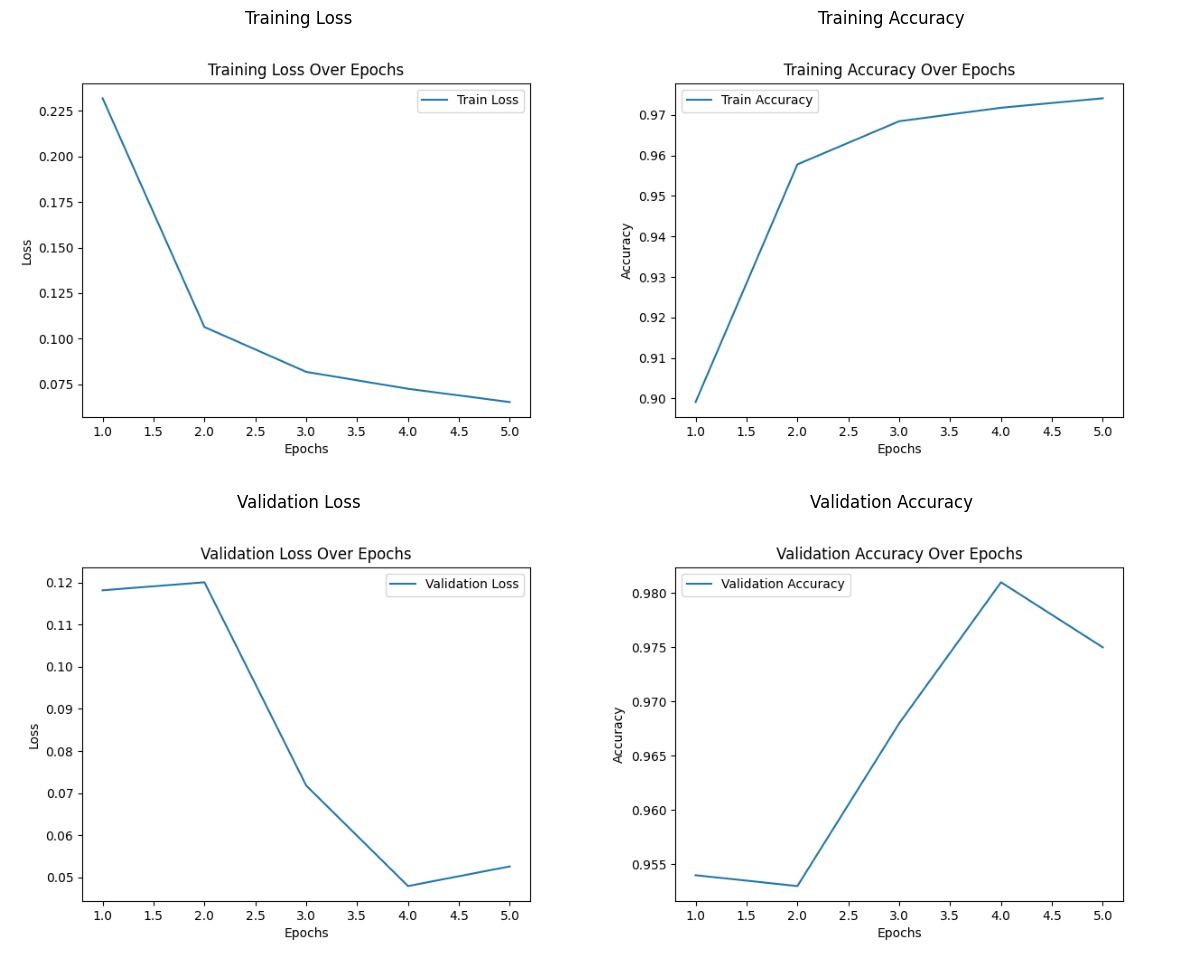

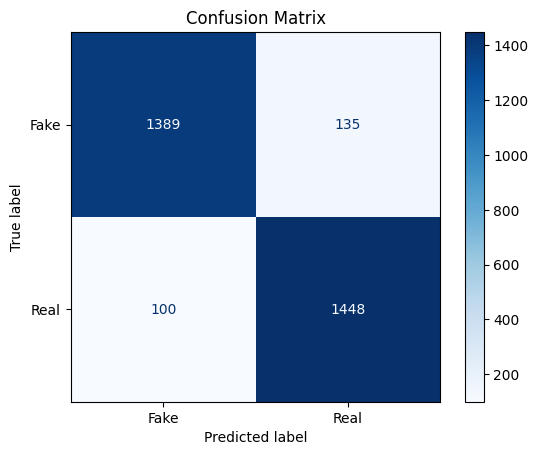

Test accuracy:  0.9235026041666666
Test loss:  0.27270478435093537


Testing model 1:   0%|          | 0/96 [00:00<?, ?it/s]

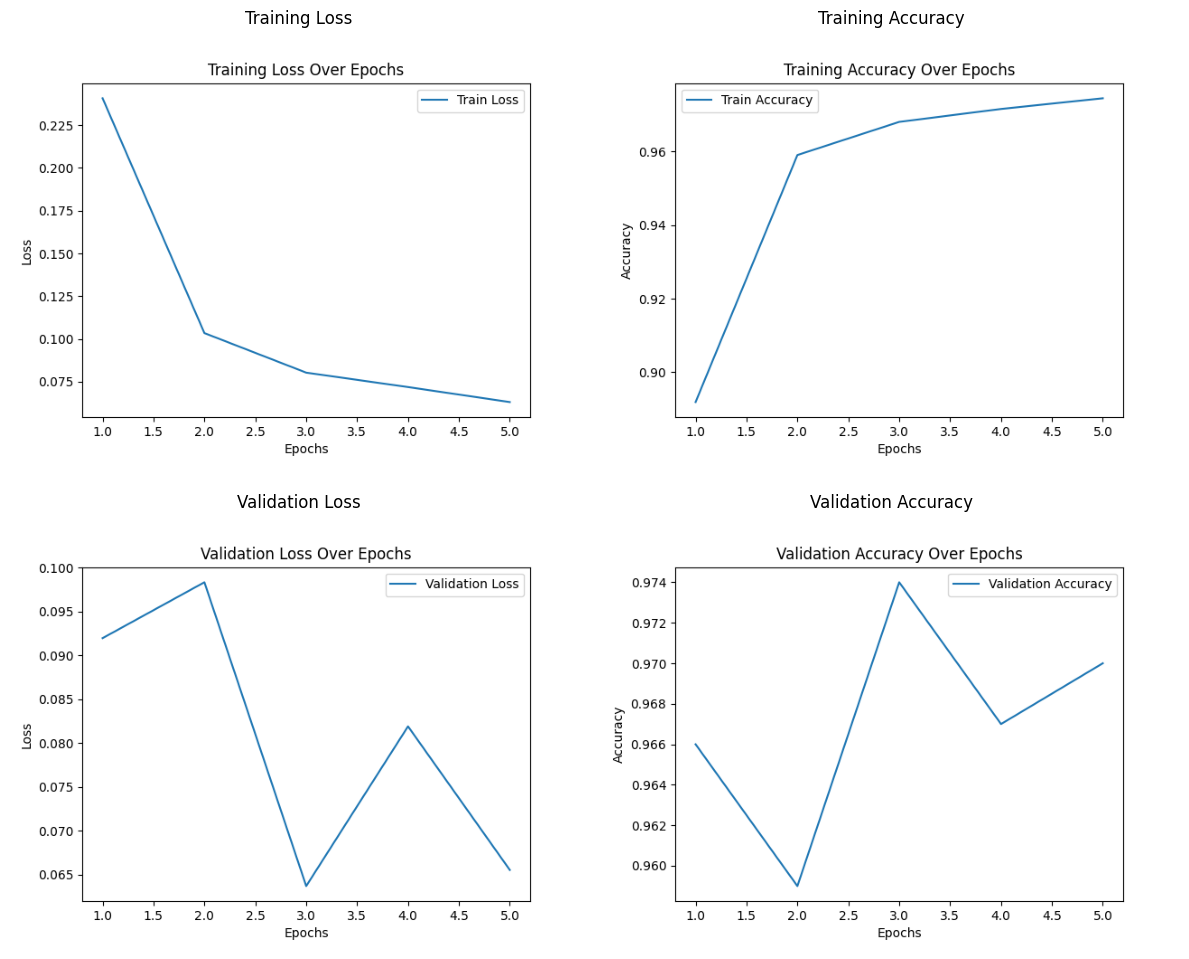

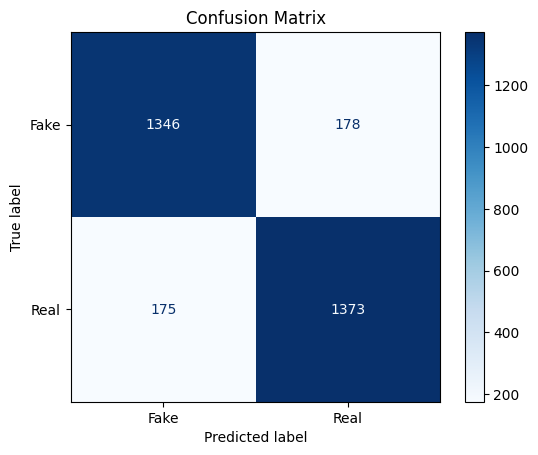

Test accuracy:  0.8850911458333334
Test loss:  0.35164307670978207


Testing model 2:   0%|          | 0/96 [00:00<?, ?it/s]

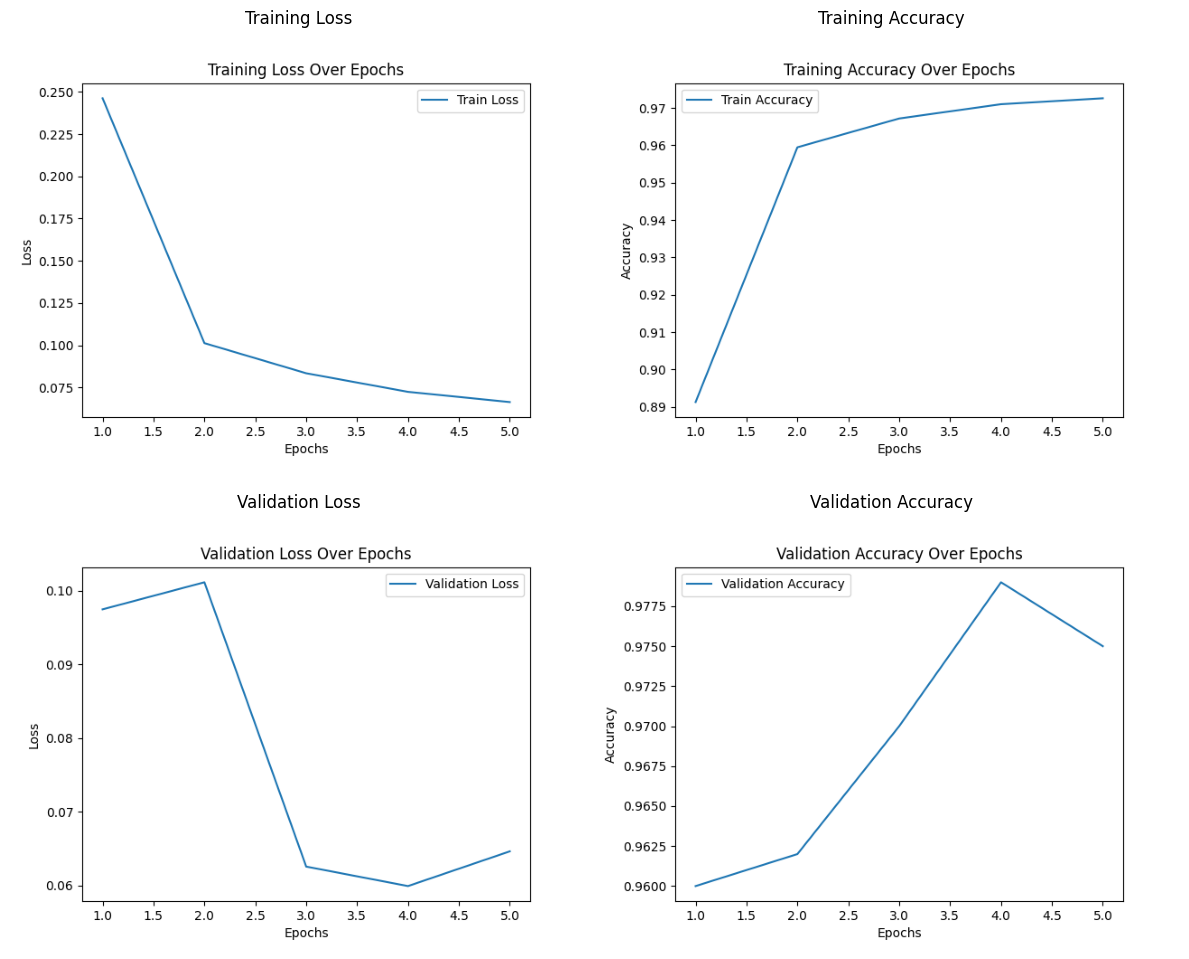

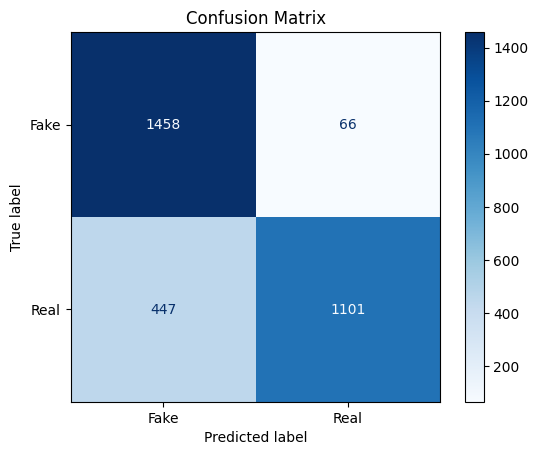

Test accuracy:  0.8330078125
Test loss:  0.5337489492570361


Testing model 3:   0%|          | 0/96 [00:00<?, ?it/s]

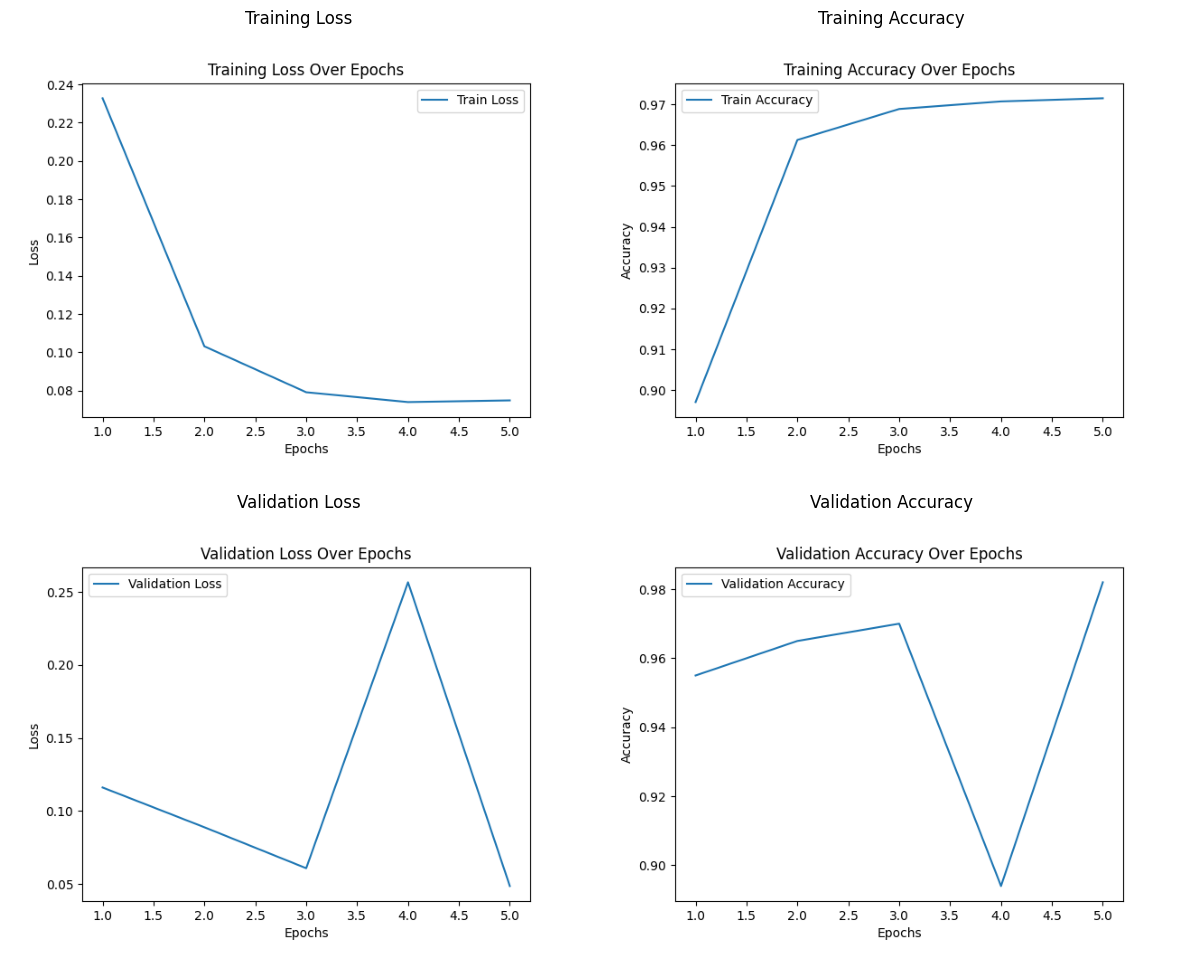

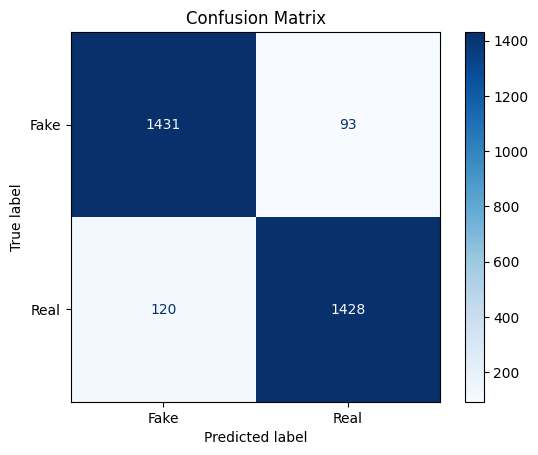

Test accuracy:  0.9306640625
Test loss:  0.26263804353463155


Testing model 4:   0%|          | 0/96 [00:00<?, ?it/s]

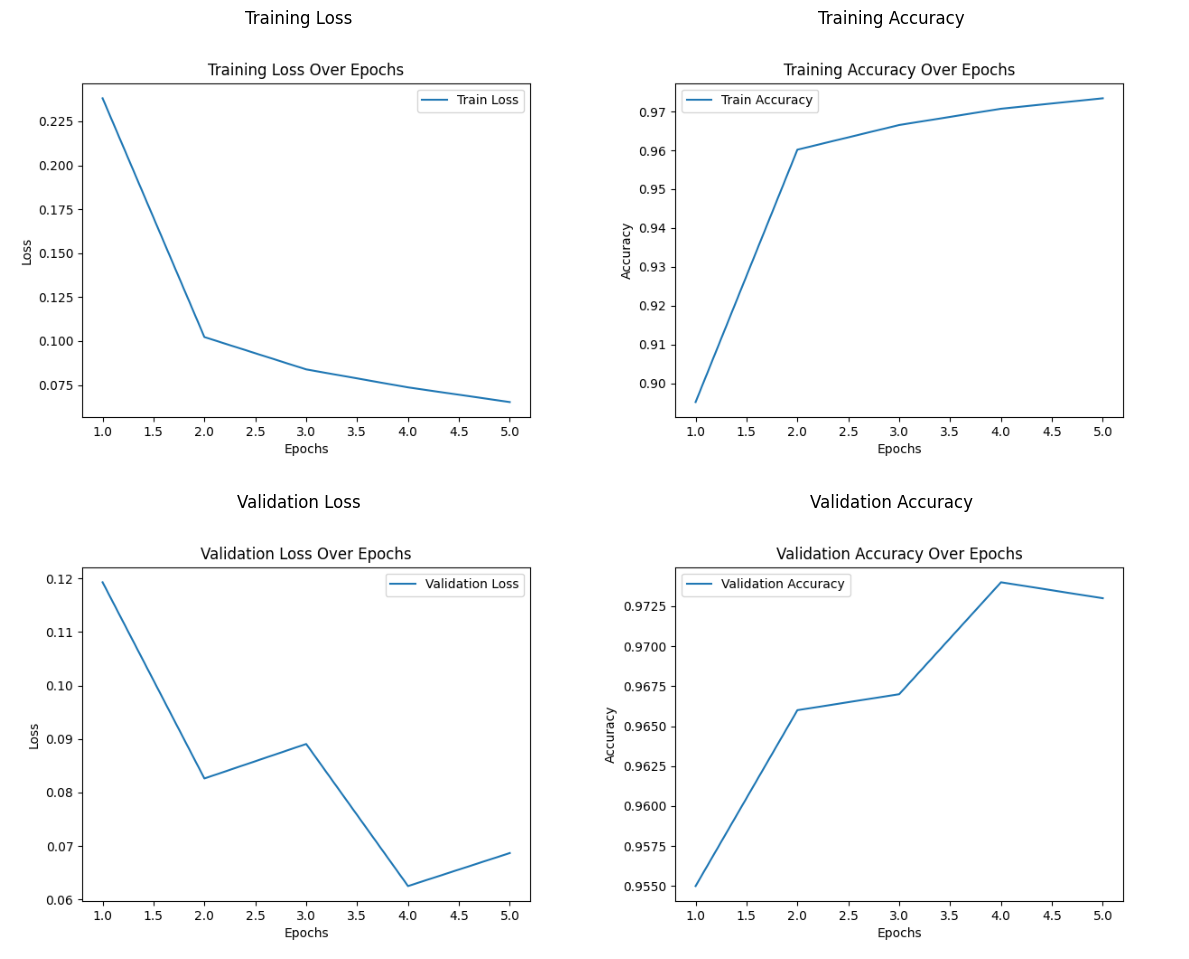

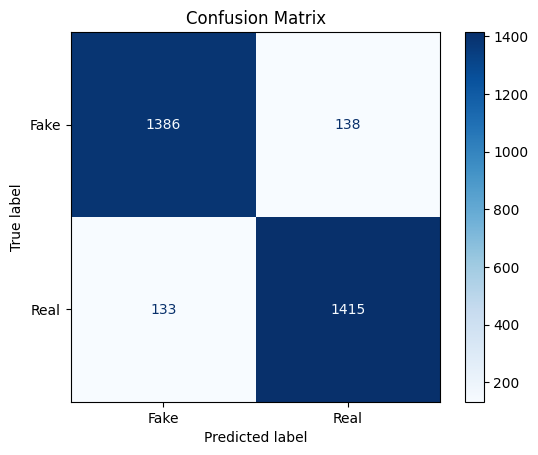

Test accuracy:  0.9117838541666666
Test loss:  0.2942965910769999


Testing models:   0%|          | 0/96 [00:00<?, ?it/s]

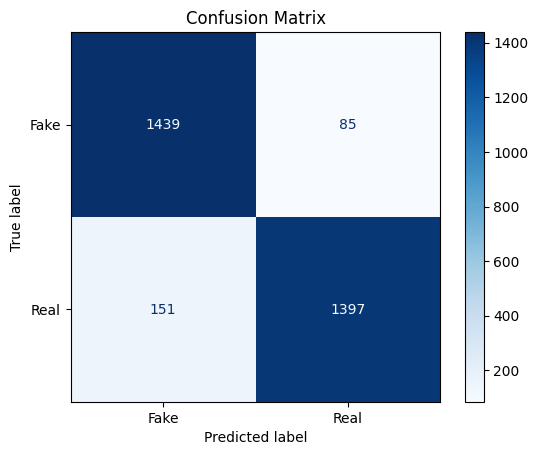

Test accuracy:  0.9231770833333334


In [3]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter('ignore', FutureWarning)

import os
import sys
import tempfile
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import pandas as pd
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.image as mpimg
import numpy as np
import random
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, DistributedSampler


class FeatureExtractor(nn.Module):
    def __init__(self, freeze_backbone = True):
        super(FeatureExtractor, self).__init__()
        efficientnet = models.efficientnet_b4(pretrained=True)
        if freeze_backbone:
            for param in efficientnet.parameters():
                param.requires_grad = False
        self.features = efficientnet.features

    def forward(self, x, target_block=None):
        if target_block == 8:
            return self.features(x)
        layers_output = {}
        for idx, layer in enumerate(self.features):
            x = layer(x)
            layers_output[idx] = x
            # Stop processing if the target block is reached
            if target_block is not None and idx == target_block:
                break
        if target_block is None:
            target_block = 8
        return layers_output[target_block]

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # First Convolutional Block
        self.conv1 = nn.Conv2d(1792, 1024, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Convolutional Block
        self.conv3 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)  # Binary classification

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        # Flatten
        x = x.view(x.size(0), -1)
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

class DeepFakeClassifier(nn.Module):
    def __init__(self, texture_layer, freeze_backbone):
        super(DeepFakeClassifier, self).__init__()
        self.feature_extractor = FeatureExtractor(freeze_backbone)
        self.classifier = Classifier()
        self.texture_layer = texture_layer

    def forward(self, x):
        x = self.feature_extractor(x, self.texture_layer)
        x = self.classifier(x)
        return x

def display_saved_plots(split):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import os

    # File paths for the saved plots
    base_path = '/kaggle/working/'
    train_loss_path = os.path.join(base_path, f'training_loss_plot-{split}.png')
    train_accuracy_path = os.path.join(base_path, f'training_accuracy_plot-{split}.png')
    val_loss_path = os.path.join(base_path, f'validation_loss_plot-{split}.png')
    val_accuracy_path = os.path.join(base_path, f'validation_accuracy_plot-{split}.png')

    # Load images
    train_loss_img = mpimg.imread(train_loss_path)
    train_accuracy_img = mpimg.imread(train_accuracy_path)
    val_loss_img = mpimg.imread(val_loss_path)
    val_accuracy_img = mpimg.imread(val_accuracy_path)

    # Display in a 2x2 grid
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(train_loss_img)
    plt.axis('off')
    plt.title('Training Loss')

    plt.subplot(2, 2, 2)
    plt.imshow(train_accuracy_img)
    plt.axis('off')
    plt.title('Training Accuracy')

    plt.subplot(2, 2, 3)
    plt.imshow(val_loss_img)
    plt.axis('off')
    plt.title('Validation Loss')

    plt.subplot(2, 2, 4)
    plt.imshow(val_accuracy_img)
    plt.axis('off')
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.show()


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['image_path']
        label = row['label']
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def test_model(model, dataloader, criterion, device, split):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    predictions = []
    real = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Testing model {split}"):
            images, labels = images.to(device), labels.to(device, dtype=torch.float32)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            preds = (outputs > 0.5).float()
            predictions.extend(preds.cpu().numpy())
            real.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            del images, labels, outputs
            torch.cuda.empty_cache()
    return total_loss / total, correct / total, predictions, real

final_df = pd.read_csv('/kaggle/working/image_paths_dataframe.csv')
test_df = final_df[(final_df['train_val_test'] == 'test')]
test_dataset = CustomDataset(test_df, transform=transform)
test_loader = train_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
texture_layer = 8
models_trained = []
device = 'cuda'
criterion = nn.BCELoss()

for split in range(5):
    final_model_path = os.path.join('/kaggle/working/', f'final_best_model-{split}.pth')
    model = DeepFakeClassifier(texture_layer, True).to(device)
    model.load_state_dict(torch.load(final_model_path, map_location=device))
    loss, acc, preds, real = test_model(model, test_loader, criterion, device, split)
    display_saved_plots(split)
    cm = confusion_matrix(real, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    print("Test accuracy: ", acc)
    print("Test loss: ", loss)
    models_trained.append(model)


def test_ensemble(models, dataloader, device):
    total_loss = 0
    correct = 0
    total = 0
    predictions = []
    real = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Testing models"):
            images, labels = images.to(device), labels.to(device, dtype=torch.float32)
            ensembled_output = torch.zeros(labels.shape).cuda()
            for model in models:
                ensembled_output += model(images).squeeze()
            ensembled_output = ensembled_output / len(models)
            preds = (ensembled_output > 0.5).float()
            predictions.extend(preds.cpu().numpy())
            real.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            del images, labels, ensembled_output
            torch.cuda.empty_cache()
    return correct / total, predictions, real

acc, preds, real = test_ensemble(models_trained, test_loader, device)
cm = confusion_matrix(real, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
print("Test accuracy: ", acc)